# Investigating Noise

In this example, we investigate how a program might behave on a near-term device that is subject to noise using the convenience function `add_decoherence_noise`.

In [1]:
from pyquil import Program
from pyquil.paulis import PauliSum, PauliTerm, exponentiate, exponential_map
from pyquil.gates import MEASURE, H, Z, RX, RZ, CZ
import numpy as np

## The task
We want to prepare $e^{i \theta XY}$ and measure it in the $Z$ basis.

In [2]:
from numpy import pi
theta = pi/3
xy = PauliTerm('X', 0) * PauliTerm('Y', 1)

### The idiomatic Pyquil program

In [3]:
prog = exponential_map(xy)(theta)
print(prog)

H 0
RX(pi/2) 1
CNOT 0 1
RZ(2*pi/3) 1
CNOT 0 1
H 0
RX(-pi/2) 1



### The compiled program
To run on a real device, we must compile each program to the native gate set for the device. The high-level noise model is similarly constrained to use a small, native gate set. In particular, we can use

 - $I$
 - $RZ(\theta)$
 - $RX(\pm \pi/2)$
 - $CZ$

For simplicity, the compiled program is given below but generally you will want to use a compiler to do this step for you.

In [4]:
def get_compiled_prog(theta):
    return Program([
        RZ(-pi/2, 0),
        RX(-pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RZ(-pi/2, 1),
        RX(-pi/2, 1),
        RZ(theta, 1),
        RX( pi/2, 1),
        CZ(1, 0),
        RX( pi/2, 0),
        RZ( pi/2, 0),
        RZ(-pi/2, 1),
        RX( pi/2, 1),
        RZ(-pi/2, 1),
    ])

## Scan over noise parameters
We perform a scan over three levels of noise each at 20 theta points.

Specifically, we investigate T1 values of 1, 3, and 10 us. By default, T2 = T1 / 2, 1 qubit gates take 50 ns, and 2 qubit gates take 150 ns. 

In alignment with the device, $I$ and parametric $RZ$ are noiseless while $RX$ and $CZ$ gates experience 1q and 2q gate noise, respectively.

In [5]:
from pyquil import get_qc
qc = get_qc('8q-qvm')

In [6]:
t1s = np.logspace(-6, -5, num=3)
thetas = np.linspace(-pi, pi, num=20)
t1s * 1e6 # us

array([ 1.        ,  3.16227766, 10.        ])

In [7]:
from pyquil.noise import add_decoherence_noise
records = []
for theta in thetas:
    for t1 in t1s:
        prog = get_compiled_prog(theta)
        ro = prog.declare("ro", memory_size=2)
        noisy = add_decoherence_noise(prog, T1=t1, T2=t1/2).inst([
            MEASURE(0, ro[0]),
            MEASURE(1, ro[1]),
        ])
        bitstrings = np.array(qc.run(noisy.wrap_in_numshots_loop(1000)))
        
        # Expectation of Z0 and Z1
        z0, z1 = 1 - 2*np.mean(bitstrings, axis=0)
        
        # Expectation of ZZ by computing the parity of each pair
        zz = 1 - (np.sum(bitstrings, axis=1) % 2).mean() * 2 
        
        record = {
            'z0': z0,
            'z1': z1,
            'zz': zz,
            'theta': theta,
            't1': t1,
        }
        records += [record]

## Plot the results

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

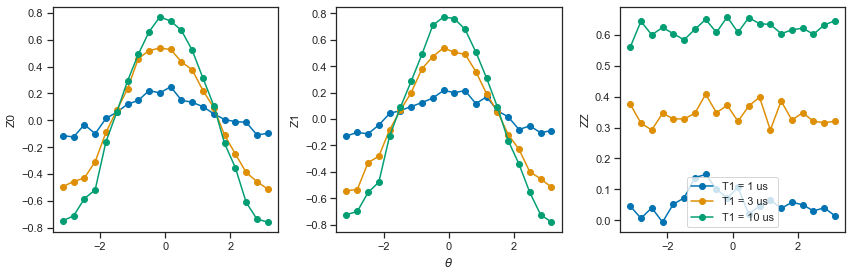

In [9]:
import pandas as pd
df_all = pd.DataFrame(records)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

for t1 in t1s:
    df = df_all.query('t1 == @t1')
    
    ax1.plot(df['theta'], df['z0'], 'o-')    
    ax2.plot(df['theta'], df['z1'], 'o-')    
    ax3.plot(df['theta'], df['zz'], 'o-', label='T1 = {:.0f} us'.format(t1*1e6))
    
ax3.legend(loc='best')

ax1.set_ylabel('Z0')
ax2.set_ylabel('Z1')
ax3.set_ylabel('ZZ')
ax2.set_xlabel(r'$\theta$')
fig.tight_layout()